In [ ]:
!unzip 'drive/MyDrive/flowers.zip' -d 'drive/MyDrive/data/'

Streaming output truncated to the last 5000 lines.
  inflating: drive/MyDrive/data/flowers/sunflower/21728822928_9f6817325a_n.jpg  
  inflating: drive/MyDrive/data/flowers/sunflower/21796333524_38fc8e0ab5_n.jpg  
  inflating: drive/MyDrive/data/flowers/sunflower/21821266773_7113d34c35_m.jpg  
  inflating: drive/MyDrive/data/flowers/sunflower/21984860006_20dfacea1c_m.jpg  
  inflating: drive/MyDrive/data/flowers/sunflower/21995435890_e5672244a4_m.jpg  
  inflating: drive/MyDrive/data/flowers/sunflower/22183521655_56221bf2a4_n.jpg  
  inflating: drive/MyDrive/data/flowers/sunflower/22183529245_ce13557515_m.jpg  
  inflating: drive/MyDrive/data/flowers/sunflower/22203670478_9ec5c2700b_n.jpg  
  inflating: drive/MyDrive/data/flowers/sunflower/22255608949_172d7c8d22_m.jpg  
  inflating: drive/MyDrive/data/flowers/sunflower/22405882322_d4561f8469_n.jpg  
  inflating: drive/MyDrive/data/flowers/sunflower/22405887122_75eda1872f_m.jpg  
  inflating: drive/MyDrive/data/flowers/sunflower/22416421

In [11]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

# Check for TPU
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.4.1
Hub version: 0.12.0
GPU available (YESS!!!!)


In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

In [1]:
input = 'drive/MyDrive/data/flowers'
output = 'drive/MyDrive/flowers_data'
splitfolders.ratio(input,output,seed = 222, ratio = (0.6,0.2,0.2))

NameError: ignored

In [2]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential,Model 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
img_width, img_height = (224,224)
batch_size = 32
train_data_directory = "drive/MyDrive/flowers_data/train"
val_data_directory = "drive/MyDrive/flowers_data/val"
test_data_directory = "drive/MyDrive/flowers_data/test"

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)

In [5]:
train_generator = train_datagen.flow_from_directory(train_data_directory, 
                                                    target_size=(img_width, img_height), 
                                                    class_mode='categorical', 
                                                    batch_size=batch_size)
val_generator = val_datagen.flow_from_directory(val_data_directory, 
                                                    target_size=(img_width, img_height), 
                                                    class_mode='categorical', 
                                                    batch_size=batch_size)

Found 21156 images belonging to 196 classes.
Found 7004 images belonging to 196 classes.


In [6]:
test_generator = test_datagen.flow_from_directory(test_data_directory, 
                                                    target_size=(img_width, img_height), 
                                                    class_mode='categorical', 
                                                    batch_size=1)

Found 7228 images belonging to 196 classes.


In [7]:
x,y = test_generator.next()
x.shape

(1, 224, 224, 3)

In [8]:
INPUT_SHAPE = [None, img_height, img_width, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = train_generator.num_classes

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/tensorflow/efficientnet/b0/classification/1"

In [9]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [12]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/tensorflow/efficientnet/b0/classification/1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1000)              5330564   
_________________________________________________________________
dense (Dense)                (None, 196)               196196    
Total params: 5,526,760
Trainable params: 196,196
Non-trainable params: 5,330,564
_________________________________________________________________


In [13]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [14]:
import datetime
import os
# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/MyDrive/flowers_data/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [15]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=2)

In [16]:
NUM_EPOCHS = 10 #@param {type:"slider", min:5, max:100, step:5}

In [17]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_generator,
            epochs=NUM_EPOCHS,
            validation_data=val_generator,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

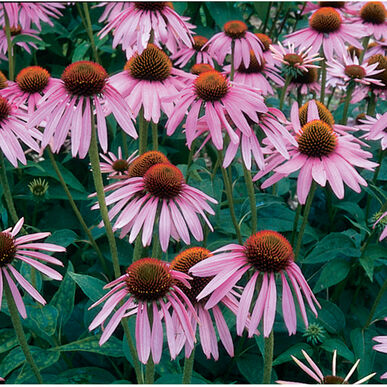

In [18]:
from IPython.display import display, Image
Image("drive/MyDrive/flowers_data/train/Echinacea/Echinacea_107.jpg")

In [19]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [20]:
#Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/tensorflow/efficientnet/b0/classification/1
Epoch 1/10
  5/662 [..............................] - ETA: 1:42:58 - loss: 5.2773 - accuracy: 0.0129

KeyboardInterrupt: ignored

In [ ]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/MyDrive/Data/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
# Save our model trained on whole images
save_model(model, suffix="images-mobilenetv3-Adam")

Saving model to: drive/MyDrive/Data/models/20210416-09101618564213-images-mobilenetv2-Adam.h5...


'drive/MyDrive/Data/models/20210416-09101618564213-images-mobilenetv2-Adam.h5'

In [ ]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path, 
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
model = load_model('drive/MyDrive/Data/models/20210416-09101618564213-images-mobilenetv2-Adam.h5')

Loading saved model from: drive/MyDrive/Data/models/20210416-09101618564213-images-mobilenetv2-Adam.h5


In [ ]:
test_loss, test_acc = model.evaluate(test_generator, verbose=1)

7228/7228 [==============================] - 129s 18ms/step - loss: 1.4129 - accuracy: 0.6904


In [ ]:
predictions = model.predict(test_generator, verbose=2)
predictions

7228/7228 - 113s


array([[5.3352198e-18, 1.5861115e-21, 1.6057744e-15, ..., 1.1690988e-18,
        2.9353411e-16, 1.3964210e-10],
       [5.2109185e-11, 1.1320400e-14, 2.8993729e-11, ..., 1.4438562e-13,
        3.8713754e-12, 2.6207480e-12],
       [1.5988033e-09, 1.6723274e-15, 1.9202156e-03, ..., 2.8263053e-14,
        1.0973199e-09, 1.8872501e-12],
       ...,
       [1.8368276e-04, 3.2519972e-06, 2.1870353e-11, ..., 3.2135649e-04,
        4.0973787e-06, 3.8982023e-07],
       [4.5052421e-12, 1.8412914e-10, 1.0883389e-15, ..., 2.0747393e-16,
        1.1048465e-09, 5.6993185e-13],
       [5.0394546e-04, 7.7079094e-06, 6.7054162e-09, ..., 1.3136539e-11,
        8.3352617e-08, 7.4193755e-05]], dtype=float32)

In [ ]:
import seaborn as sn
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob = []
y_act = []
test_generator.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_generator.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

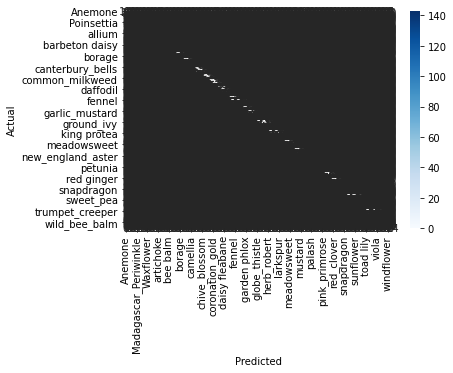

test_accuracy : 69.56281128942999


In [ ]:
predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob ]
actual_class = [list(test_generator.class_indices.keys())[i.argmax()] for i in y_act ]
out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T, columns = ['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['predicted_class'],out_df['actual_class'], rownames = ['Actual'], colnames = ['Predicted'])
sn.heatmap(confusion_matrix, cmap = 'Blues', annot = True, fmt = 'd')
plt.show()
print('test_accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

yellow iris


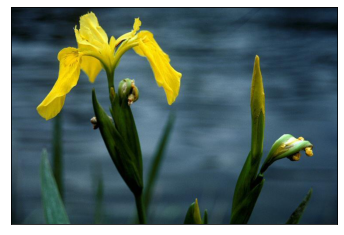

In [ ]:
import os
from keras.preprocessing import image

def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor


if __name__ == "__main__":

    # image path
    img_path = 'drive/MyDrive/flowers_data/test/yellow iris/image_06374.jpg'
    #img_path = '/media/data/dogscats/test1/19.jpg'      # cat
    # load a single image
    new_image = load_image(img_path)
    import matplotlib.image as mpimg
    plt.imshow(mpimg.imread(img_path))
    plt.xticks([])
    plt.yticks([])
    # check prediction
    pred = model.predict(new_image)
    unique_class = test_generator.class_indices
    newlist = []
    for i in unique_class.keys():
      newlist.append(i)
    print(newlist[pred.argmax()])

In [ ]:
https://tfhub.dev/google/cropnet/classifier/cassava_disease_V1/2